# Time Series Forecasting

## Outline

Explore time series forecasting with: 
- Traditional methods, (SAIRMAX)
- Gradient Boosted Machines, (XGBoost)
- and Neural Networks. (LSTM)

Referenced sources
- Notebook: https://www.kaggle.com/code/albertovidalrod/uk-electricity-consumption-prediction-time-series/notebook\
- Website: https://www.geeksforgeeks.org/complete-guide-to-sarimax-in-python/
- Dataset: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

### Import libraries

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import xgboost as xgb
from sklearn.metrics import mean_squared_error, root_mean_squared_error

import numpy as np

# split time series data for train/test
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from statsmodels.tsa.stattools import adfuller, acf, pacf

from sklearn.preprocessing import MinMaxScaler

import statsmodels.tsa.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

import datetime as dt



### Import and check data

In [2]:
# import first column as index and parse date as datetime
pjm_df = pd.read_csv('./Data_PJM/PJME_hourly.csv', index_col=0, parse_dates=True)

In [3]:
pjm_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [4]:
pjm_df.isna().sum()

PJME_MW    0
dtype: int64

In [5]:
pjm_df.sort_index().head(5)

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


### Visualise data

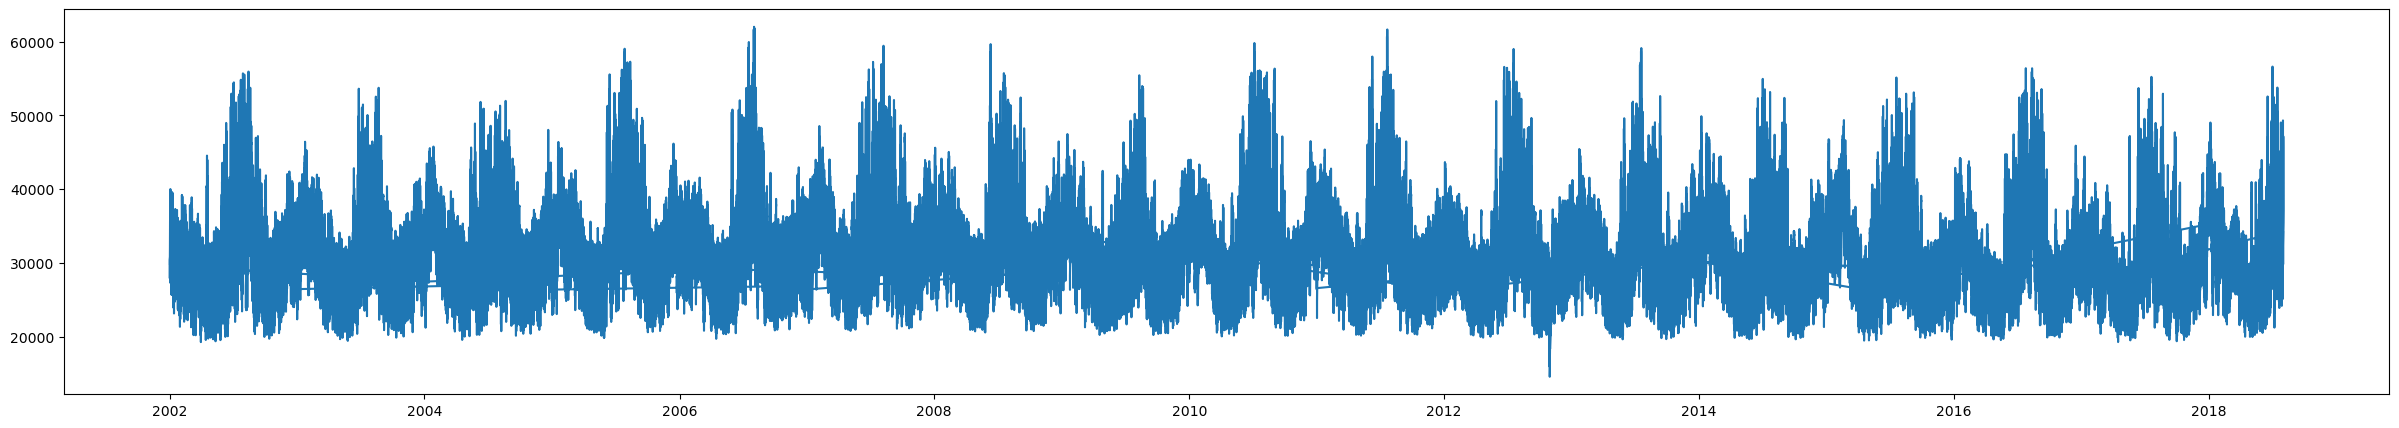

In [6]:
plt.figure(figsize=(30,5))

plt.plot(pjm_df)

Comment: 
1. There appears to be repeating patterns in the time series. Perhaps indicating seasonality.
2. Notice outlier data dipping below 20K MW. To remove outlier as it will affect the train result.

### Remove outlier data

In [7]:
pjm_df_clean = pjm_df.query('PJME_MW >= 20_000')

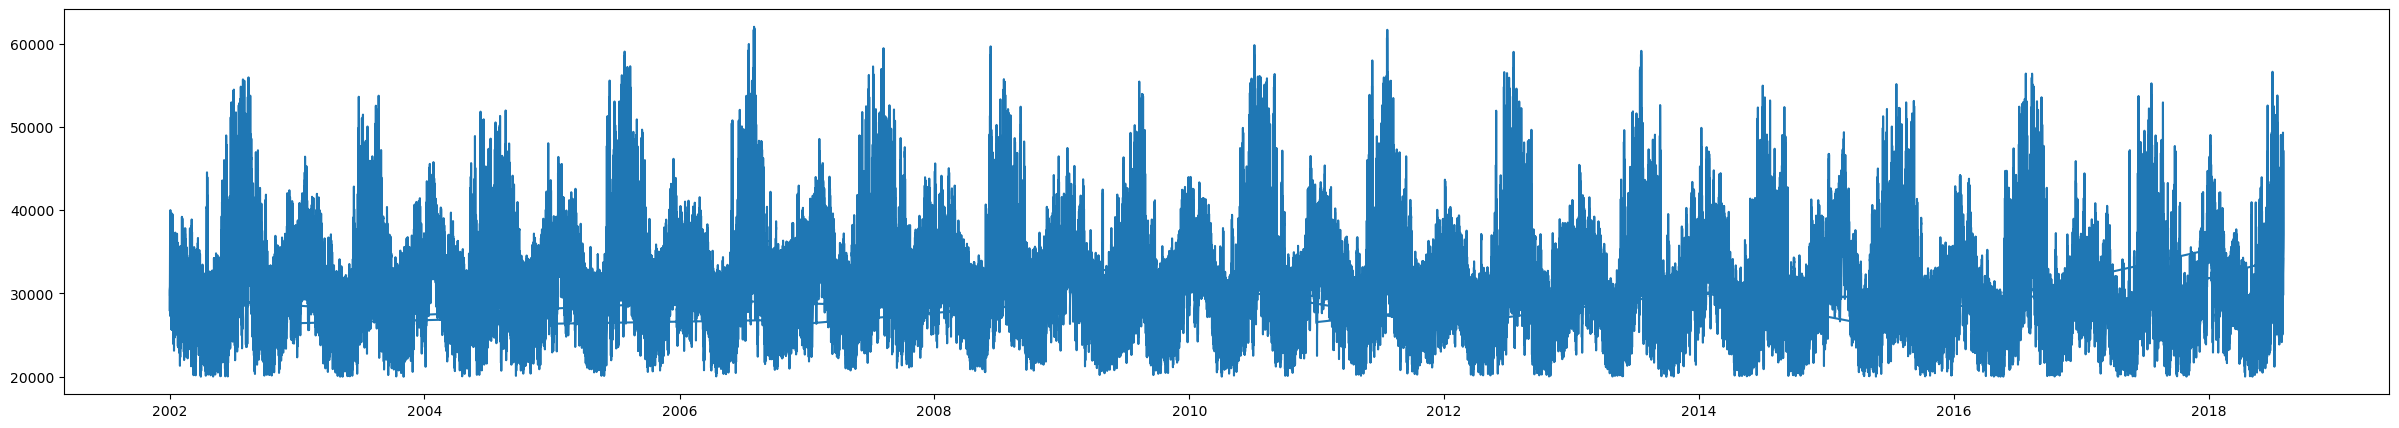

In [8]:
plt.figure(figsize=(30,5))
plt.plot(pjm_df_clean)

### Items to check

1. Check that the mean of the dataset remains constant (ADF)
2. Check if variance of the dataset remains contant (ADF)
3. Check for seasonality in dataset

### ADF test

In [9]:
print(f'Test Statistic: {adfuller(pjm_df_clean)[0]}')
print(f'p-value: {adfuller(pjm_df_clean)[1]}')

Test Statistic: -18.807619720152807
p-value: 2.0225636177494325e-30


ADF test hypothesis:
1. H0: Time series has a unit root (non-stationary)
2. H1: Time series does not have a unit root (stationary)

Test-statistic is less than critical values (-3.43 @ 0.01, -2.86 @ 0.05, -2.57 @ 0.10).Reject null hypothesis that time series is non-stationary (has unit root)\
p-value is less than [0.01, 0.05, 0.10]. Reject null hypothesis that time series is non-stationary (has unit root)\

However, time series appears to exhibt seasonality, thus it is not stationary

Reduce data frequency to smooth out noise, via resampling by daily mean

### Resample data by day mean

In [10]:
pjm_day_mean_resample = pjm_df_clean['PJME_MW'].resample('D').mean().to_frame()
pjm_day_mean_resample.sort_index()

,PJME_MW
Datetime,
2002-01-01,31080.739130
2002-01-02,34261.541667
2002-01-03,34511.875000
2002-01-04,33715.458333
2002-01-05,30405.125000
...,...
2018-07-30,32957.416667
2018-07-31,34539.083333
2018-08-01,39230.791667


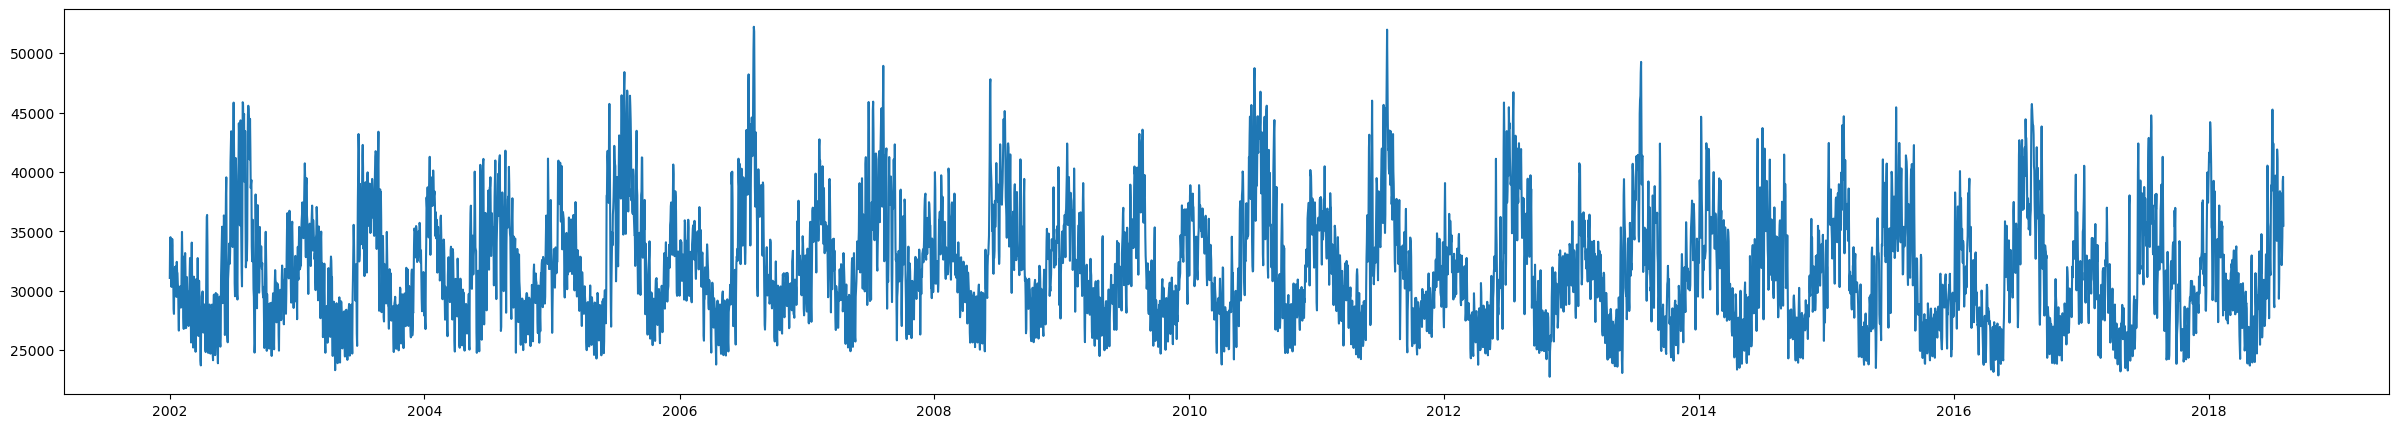

In [11]:
plt.figure(figsize=(30,5))
plt.plot(pjm_day_mean_resample)

### ADF Test

In [12]:
print(f'Test Statistic: {adfuller(pjm_day_mean_resample["PJME_MW"].dropna())[0]}')
print(f'p-value: {adfuller(pjm_day_mean_resample["PJME_MW"].dropna())[1]}')

Test Statistic: -8.273182457661077
p-value: 4.732594451764252e-13


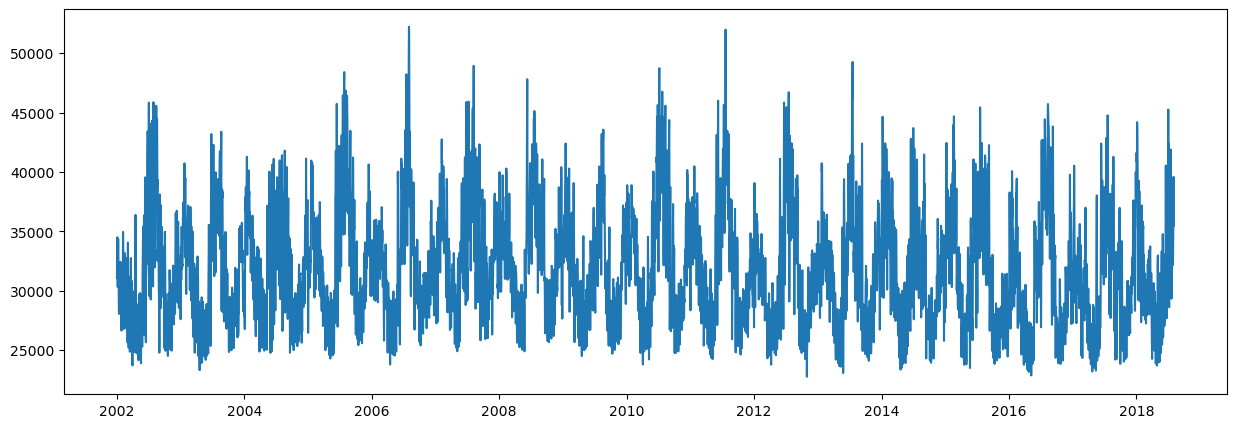

In [13]:
plt.figure(figsize=(15,5))
plt.plot(pjm_day_mean_resample["PJME_MW"])

Comment: Adfuller test on resampled daily mean indicates stationarity, where has plot indicates presence of seasonality. Within expectation. Next step to check for trend and seasonality with statsapi seasonal differences.

### Check for trend and seasonality

<Figure size 3000x500 with 0 Axes>

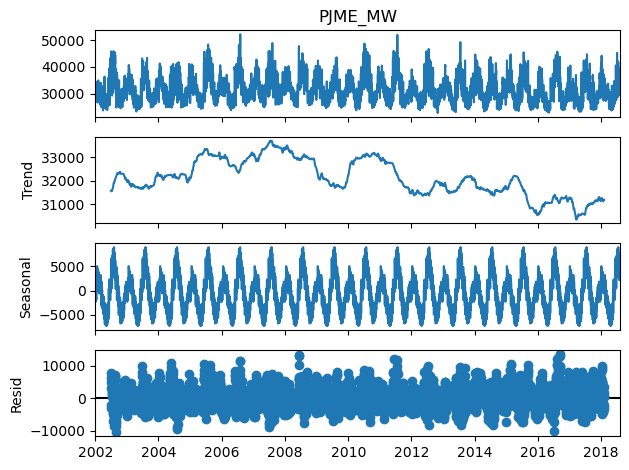

In [14]:
# decompose time series in to trend + seasonal + residual
# use to identify underlying patterns
# https://dfep.netlify.app/sec-multiple-seasaonality

plt.figure(figsize=(30,5))

# period = number of rows after which you expect your data to repeat a cycle. Since this is yearly data, period = 364
decompose = sm.seasonal_decompose(pjm_day_mean_resample['PJME_MW'].dropna(), period=364)

decompose.plot();

Comment: Trend and seasonality exist. Remove trend via differencing. Start with 1.

### Difference by 1

In [15]:
pjm_day_mean_resample['difference_day'] = pjm_day_mean_resample['PJME_MW'].diff(periods=1)

In [16]:
pjm_day_mean_resample['difference_day'].head()

Datetime
2002-01-01            NaN
2002-01-02    3180.802536
2002-01-03     250.333333
2002-01-04    -796.416667
2002-01-05   -3310.333333
Freq: D, Name: difference_day, dtype: float64

In [17]:
print(f'Test Statistic: {adfuller(pjm_day_mean_resample["difference_day"].dropna())[0]}')
print(f'p-value: {adfuller(pjm_day_mean_resample["difference_day"].dropna())[1]}')

Test Statistic: -13.148757877787355
p-value: 1.3808101362426848e-24


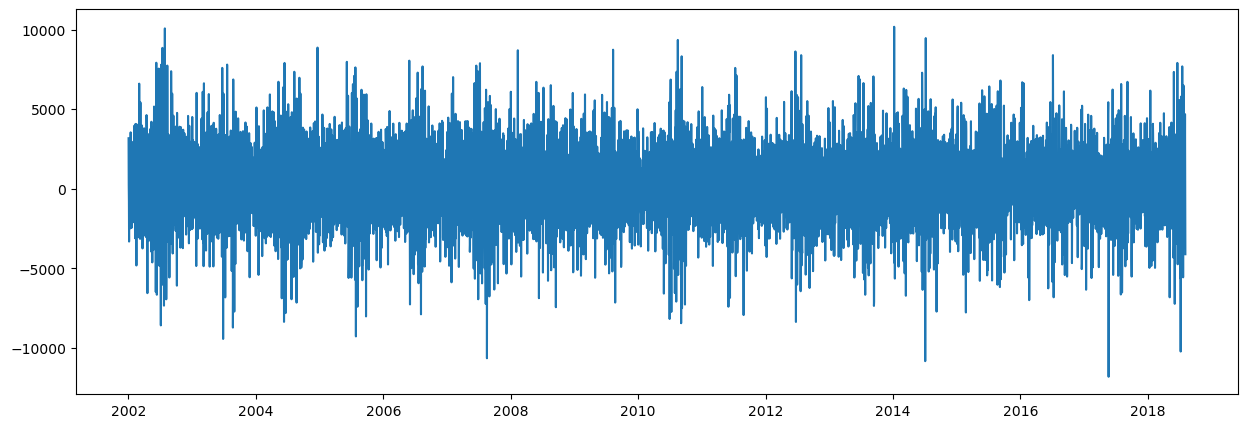

In [18]:
plt.figure(figsize=(15,5))
plt.plot(pjm_day_mean_resample["difference_day"])

Comment: 
- Adfuller results on time series data differenced by one indicates stationarity, and no presence of seasonality. Set d = 1
- Next step, remove seasonality by differencing with period of 364 (one year). Why 364? It is divisible by 7, meaning that one does not need to worry about weekdays/ weekends.

### Difference by 364

In [19]:
pjm_day_mean_resample['difference_year'] = pjm_day_mean_resample['PJME_MW'].diff(periods=364)

In [20]:
print(f'Test Statistic: {adfuller(pjm_day_mean_resample["difference_year"].dropna())[0]}')
print(f'p-value: {adfuller(pjm_day_mean_resample["difference_year"].dropna())[1]}')

Test Statistic: -10.613461923112924
p-value: 5.754357475671444e-19


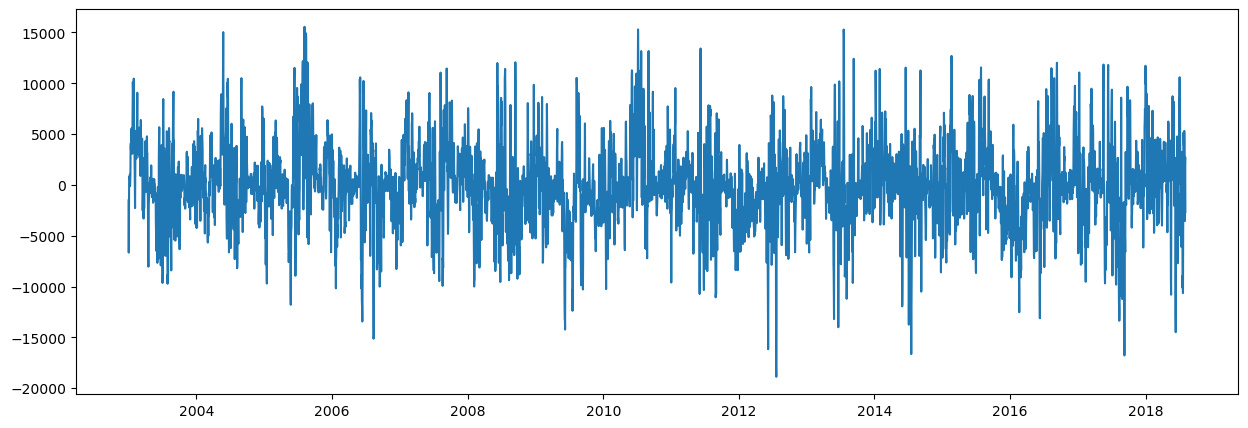

In [21]:
plt.figure(figsize=(15,5))
plt.plot(pjm_day_mean_resample["difference_year"])

Comment: One year differenced data is stationary, and doesnt exhibit seasonality. Set D = 1

### Determine p,q and P, Q - require iterative refinement
1. p = acf
2. q = pacf
3. P = acf(seasonal_decompose())
4. Q = pacf(seasonal_decompose())

### Analyse autocorrelation function and partial autocorrelation function for p and q parmeters respectively

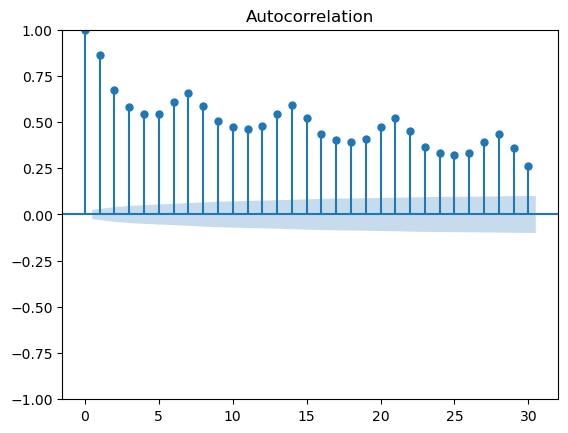

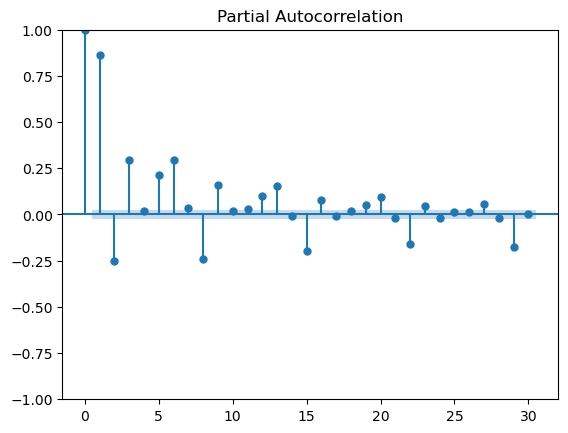

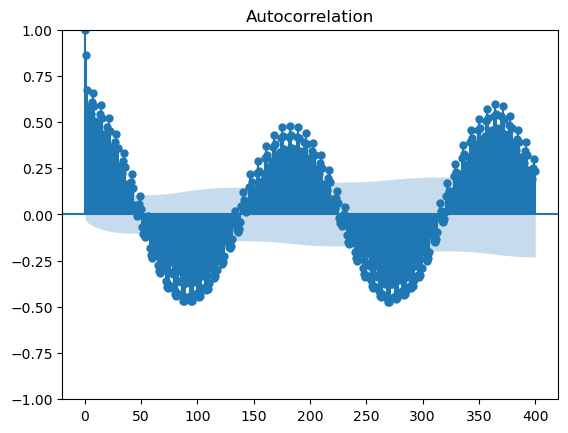

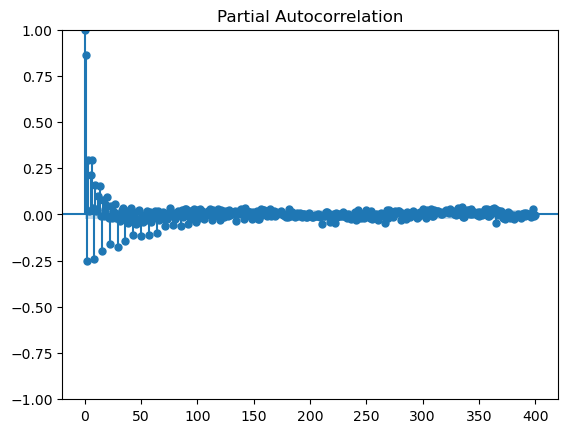

In [22]:
# plot lag 30 days
sm.graphics.plot_acf(pjm_day_mean_resample['PJME_MW'], lags=30, zero=True); # choose 30 as it extends beyond 1 to provide better visualisation
sm.graphics.plot_pacf(pjm_day_mean_resample['PJME_MW'], lags=30, zero=True, method = 'ywm');

# plot lag 400 days
sm.graphics.plot_acf(pjm_day_mean_resample['PJME_MW'], lags=400, zero=True); # choose 400 as it extends beyond 364 to provide better visualisation
sm.graphics.plot_pacf(pjm_day_mean_resample['PJME_MW'], lags=400, zero=True);

# plt.legend()

Comment:
1. acf plot indicates that there is a spike upwards at every 7th interval. Starting point for p = 7.
2. pacf plot indicates that there is a spike downards starting at 2nd interval. Starting point for q = 2.

### Analyse seasonal autocorrelation function and partial autocorrelation function for P and Q parmeters respectively

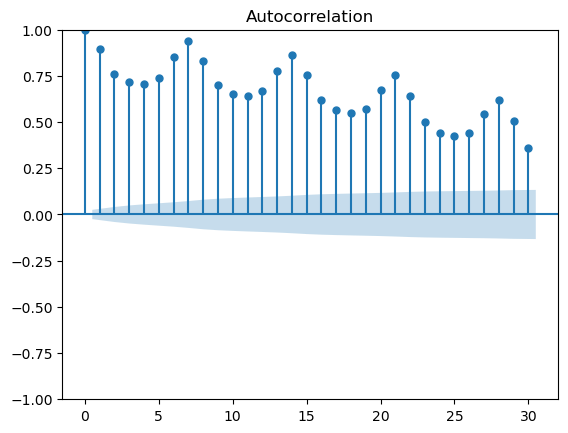

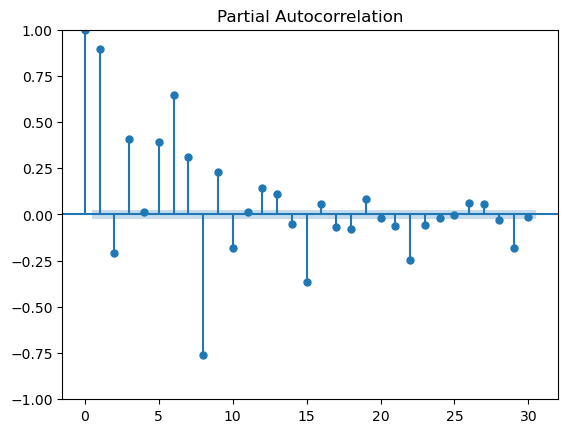

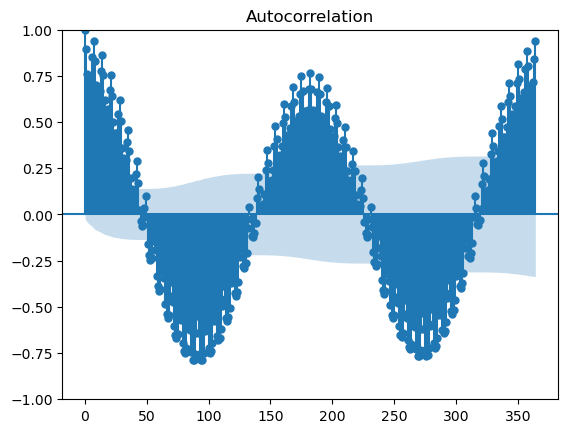

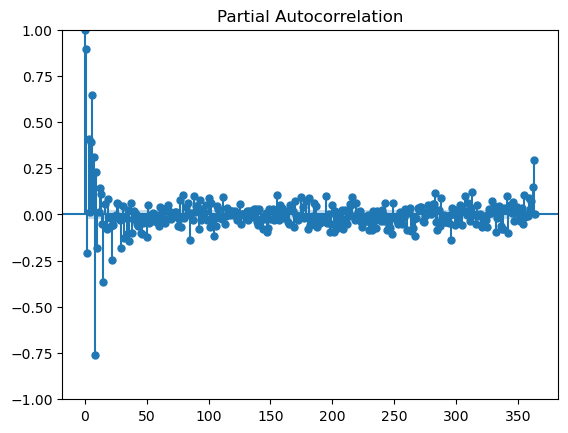

In [23]:
sm.graphics.plot_acf(decompose.seasonal, lags=30, zero=True); # choose 30 as it extends beyond 1 to provide better visualisation
sm.graphics.plot_pacf(decompose.seasonal, lags=30, zero=True);


sm.graphics.plot_acf(decompose.seasonal, lags=364, zero=True); # choose 30 as it extends beyond 1 to provide better visualisation
sm.graphics.plot_pacf(decompose.seasonal, lags=364, zero=True);

Comment:
1. seasonal acf plot indicates that there is a spike upwards at every 7th interval. Starting point for P = 7.
2. seasonal pacf plot indicates that there is a spike downards starting at 2nd interval. Starting point for Q = 2.

### Train-test split

In [24]:
split_point = int(np.ceil(len(pjm_day_mean_resample['PJME_MW']) * 0.75))

split_date = pjm_day_mean_resample.index[split_point]

print(split_date)

2014-06-12 00:00:00


In [25]:
X_train = pjm_day_mean_resample.loc[:split_date, 'PJME_MW']
X_test = pjm_day_mean_resample.loc[split_date:, 'PJME_MW']

### Plot train and test set

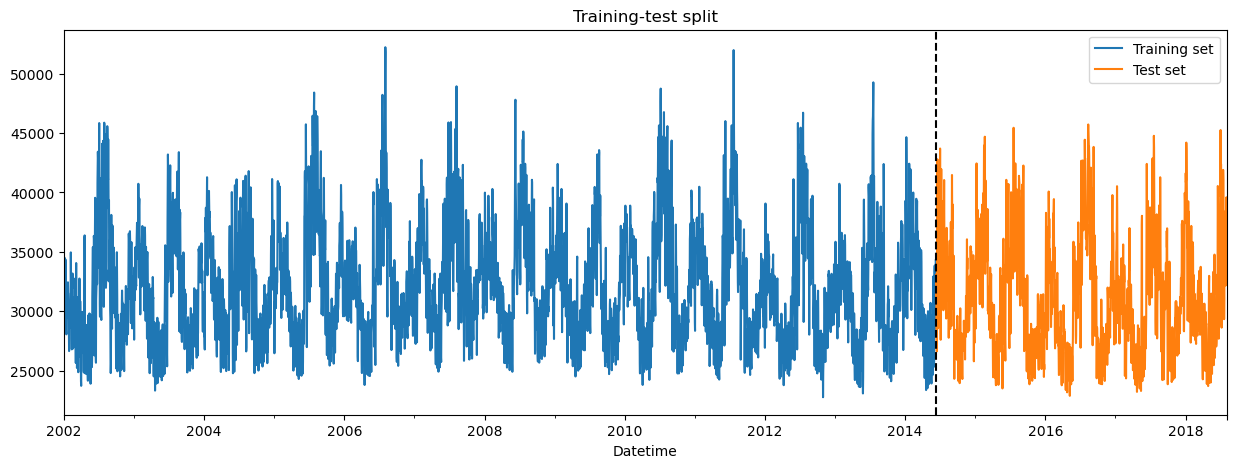

In [26]:

fig, ax = plt.subplots(figsize=(15, 5))
X_train.plot(ax=ax, label="Training set")
X_test.plot(ax=ax, label="Test set")
ax.axvline(split_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend();

### Sarimax
order=(p,d,q)\
seasonal_order=(P, D, Q, S)

1. p (AR terms) = 7
2. d (Integration order) = 1
3. q (MA terms) = 2
4. P (Seasonal AR terms) = 7
5. D (Seasonal Integration order) = 1
6. Q (Seasonal MA terms) = 2
7. seasonal_periods (number of seasonal periods) = 364

In [27]:
print(split_date)

2014-06-12 00:00:00


print(str(split_date))

In [28]:
# sarimax_model = SARIMAX(
#     endog= X_train,
#     order = (7,1,2),
#     seasonal_order= (7,1,2,364)
# )

# results = sarimax_model.fit()

# predict = results.predict(start=str(split_date), end=str(X_test.index[-1].date()))  

# rmse = root_mean_squared_error(X_test.values, predict.values)

# print(results.summary())
# print(rmse)

### Plot ground truth vs prediction

In [29]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(predict, label="Prediction")
# ax.plot(X_test, label="Test data")
# # ax.fill_between(
# #     confidence_int.index,
# #     confidence_int["lower tsd"],
# #     confidence_int["upper tsd"],
# #     alpha=0.3,
# # )
# ax.set_title("Prediction on test data")
# ax.set_ylabel("Total power consumption (MW)")
# ax.legend()

In [30]:
# sarimax_results = SARIMAXResults(results)

# confidence_int = sarimax_results.conf_int(alpha=0.05)
# prediction = sarimax_results.predicted_mean

# print(confidence_int)
# print(prediction)

### XGBoost

Explore using XGBoost to perform regresion on time series data

### Create Features

In [31]:
def create_features(df):
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear

    return df

In [32]:
# use data cleaned of outliers
# sort index to make sure the timeseries data is in order

xgb_df = create_features(pjm_df_clean.sort_index())
xgb_df.head(2)

,PJME_MW,hour,month,quarter,year,dayofweek,dayofyear
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,2002,1,1
2002-01-01 02:00:00,29265.0,2,1,1,2002,1,1


In [33]:
FEATURES = [
    'hour',
    'dayofweek',
    'month',
    'quarter',
    'year',
    'dayofyear',
]

TARGET = 'PJME_MW'

In [34]:
# set train size
train_size = 0.75
split_index = int(len(xgb_df) * train_size)
split_date = xgb_df.index[split_index].strftime('%Y-%m-%d')
print(split_index)

108883


### Train_Test Split

In [35]:
# set train size
train_size = 0.75

# obtain the data index of train_test split
split_index = int(len(xgb_df) * train_size)

train = xgb_df.iloc[:split_index].copy()
test = xgb_df.iloc[split_index:].copy()

# split data in to train and test sets
X_train = train[FEATURES]
X_test = test[FEATURES]

y_train = train[TARGET]
y_test = test[TARGET]

In [36]:
# check data
X_train.tail(2)

,hour,dayofweek,month,quarter,year,dayofyear
Datetime,,,,,,
2014-06-09 10:00:00,10,0,6,2,2014,160
2014-06-09 11:00:00,11,0,6,2,2014,160


In [37]:
# check data
X_test.head(2)

,hour,dayofweek,month,quarter,year,dayofyear
Datetime,,,,,,
2014-06-09 12:00:00,12,0,6,2,2014,160
2014-06-09 13:00:00,13,0,6,2,2014,160


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

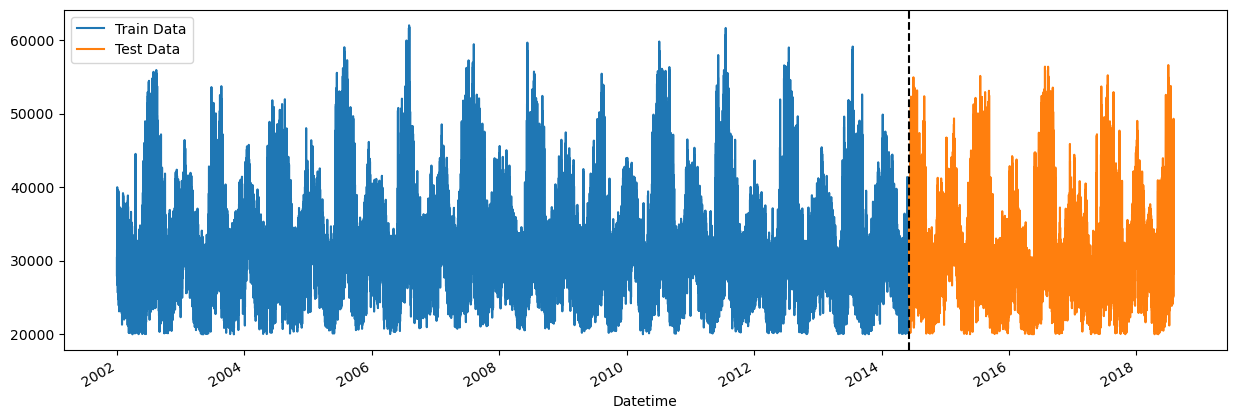

In [38]:
# visualise train and test data
fig, ax = plt.subplots(figsize = (15,5))

y_train.plot(ax=ax, label = 'Train Data')
y_test.plot(ax=ax, label = 'Test Data')

plt.axvline(split_date, ls='--', color='black')

plt.legend(loc='upper left')
plt.tight_layout

### Instantiate XGBoost model

In [39]:
# instantiate XGBoost mode
xgb_reg = xgb.XGBRegressor(
    n_estimator = 1000,
    early_stopping_round = 50,
    learning_rate = 0.01,
    random_state = 22
)

# fit model
xgb_reg.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], # evaluate train vs test data for overfit 
    verbose = 10 # print out train and validation scores after x number of trees. True = all
)

[0]	validation_0-rmse:6400.38500	validation_1-rmse:6448.21319
[10]	validation_0-rmse:5978.80061	validation_1-rmse:6057.96053
[20]	validation_0-rmse:5609.13573	validation_1-rmse:5722.33685
[30]	validation_0-rmse:5285.73075	validation_1-rmse:5432.65400
[40]	validation_0-rmse:4999.26903	validation_1-rmse:5177.26353


c:\Users\kunho\anaconda3\envs\GA\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:33:31] WARNING: D:\bld\xgboost-split_1713397764293\work\src\learner.cc:742: 
Parameters: { "early_stopping_round", "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	validation_0-rmse:4749.15067	validation_1-rmse:4958.65264
[60]	validation_0-rmse:4530.35207	validation_1-rmse:4771.92288
[70]	validation_0-rmse:4336.29493	validation_1-rmse:4610.73642
[80]	validation_0-rmse:4169.09950	validation_1-rmse:4474.73318
[90]	validation_0-rmse:4023.47828	validation_1-rmse:4358.13636
[99]	validation_0-rmse:3909.70217	validation_1-rmse:4269.97710


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_round=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimator=1000,
             n_estimators=None, n_jobs=None, ...)

Comment: 8% diff between Train and test rmse. Indicates slight overfitting

### Check Feature Importance

In [40]:
# feature_importances_ : returns weights, sum to 1.Each score ranges from 0 (least important) to 1 (most important).
# https://datascience.stackexchange.com/questions/34209/xgboost-quantifying-feature-importances/41548#41548

feature_impt = pd.DataFrame(
    data=xgb_reg.feature_importances_, 
    index=xgb_reg.feature_names_in_,
    columns=['importance'],
)

feature_impt

,importance
hour,0.240995
dayofweek,0.118176
month,0.555970
quarter,0.000000
year,0.008869
dayofyear,0.075990


<Axes: title={'center': 'Feature Importance'}>

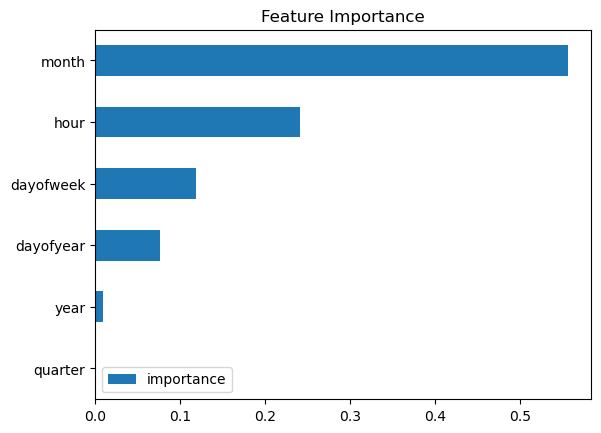

In [41]:
# visualise feature importance via plot
feature_impt.sort_values('importance').plot(kind='barh', title='Feature Importance')

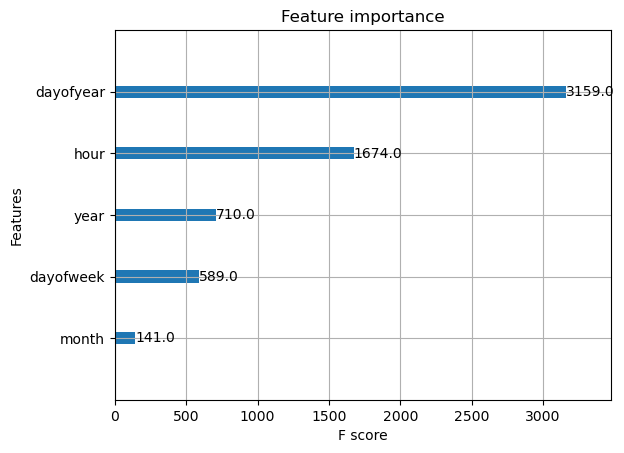

In [42]:
# plot_importance returns the number of occurrences in splits. Shows which feature is used frequently to split the data
# https://datascience.stackexchange.com/questions/34209/xgboost-quantifying-feature-importances/41548#41548
xgb.plot_importance(xgb_reg)

plt.show()

### Forecast on Test Data

In [43]:
test['Prediction'] = xgb_reg.predict(X_test)

In [44]:
rmse = root_mean_squared_error(test['PJME_MW'], test['Prediction'])
rmse

4269.977094907691

### Plot Test Ground Truth and Predicted values

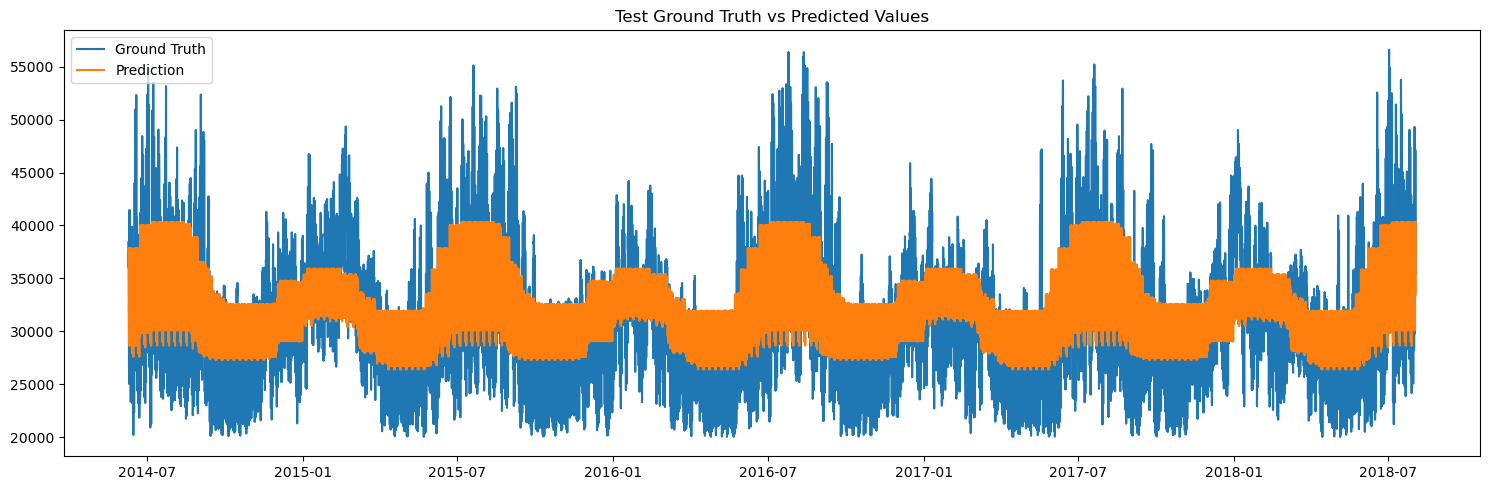

In [45]:
plt.figure(figsize=(15,5))

plt.plot(test['PJME_MW'], label='Ground Truth')
plt.plot(test['Prediction'], label = 'Prediction')

plt.title('Test Ground Truth vs Predicted Values')
plt.legend()

plt.tight_layout()

Comment: Predicted value seems quite different from ground truth.

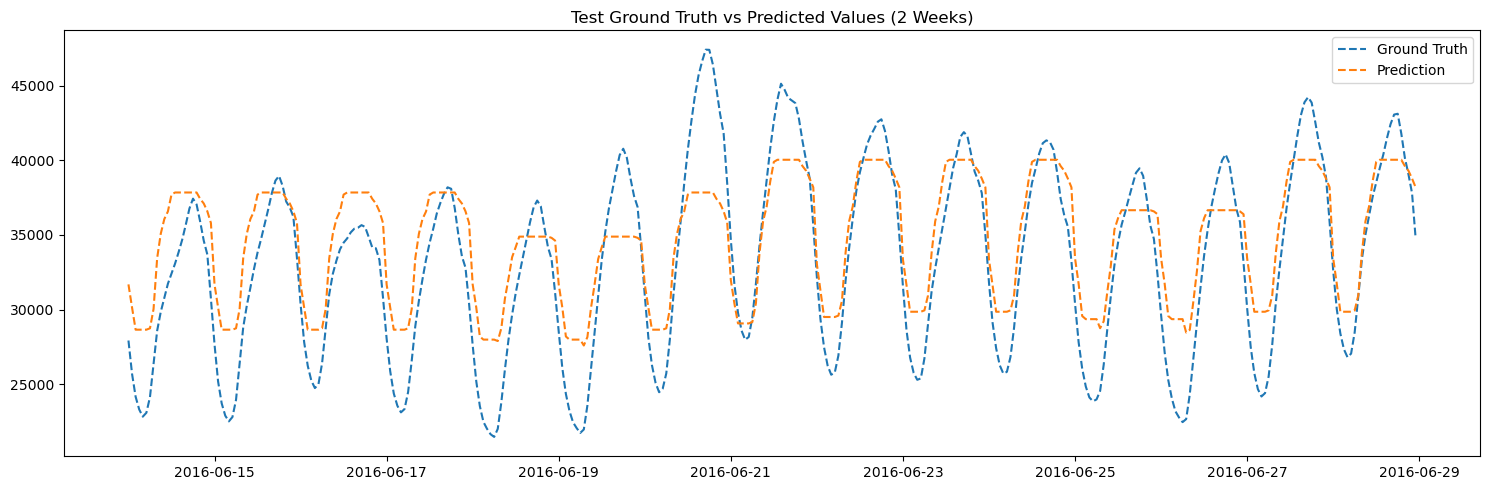

In [46]:
# check 2 weeks of data

start = '2016-06-14'
end =  '2016-06-28'

plt.figure(figsize=(15,5))

plt.plot(test.loc[start:end, :]['PJME_MW'], ls='--', label='Ground Truth')
plt.plot(test.loc[start:end, :]['Prediction'], ls='--', label = 'Prediction')

plt.title('Test Ground Truth vs Predicted Values (2 Weeks)')
plt.legend()

plt.tight_layout()

Comment: Doesnt predict peaks and troughs well.

In [47]:
xgb_merge_df = xgb_df.merge(
    test['Prediction'],
    how = 'left',
    left_index=True, # merge dataframe on the index column
    right_index=True # merge dataframe on the index column
)

Text(0.5, 1.0, 'Raw Data and Prediction')

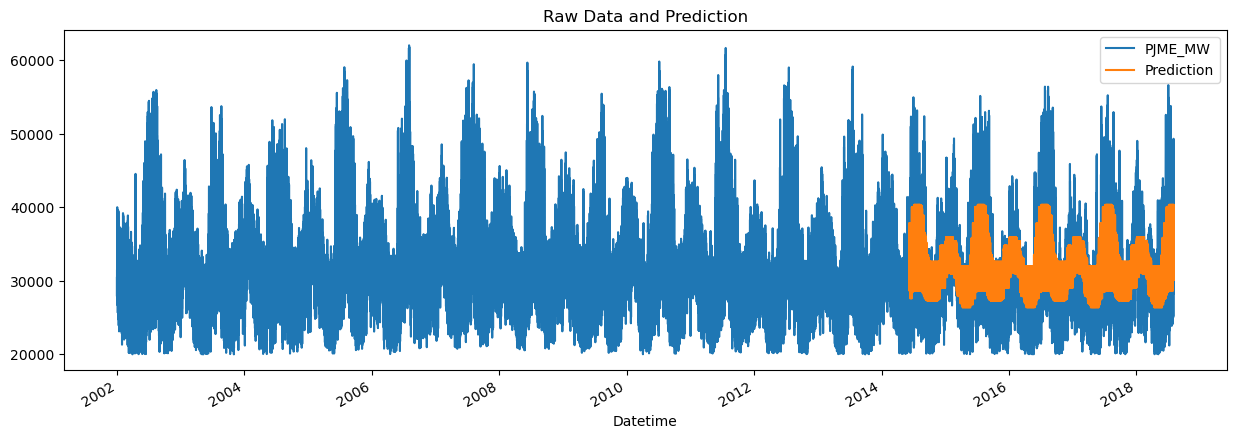

In [48]:
plt.figure(figsize=(15,5))
           
xgb_merge_df['PJME_MW'].plot()
xgb_merge_df['Prediction'].plot()

plt.legend()
plt.title('Raw Data and Prediction')

### Advance XGBoost with lag features, cross validation and GridSearchCV

### Create lag features

In [49]:
def add_lags(df):
    # df['lag_1'] = df['PJME_MW'].shift(1) # lag days cant be lower the the number of days we want to predict out in to the future. one year future prediction = min 364 days lag
    # df['lag_7'] = df['PJME_MW'].shift(7)
    df['lag_364'] = df['PJME_MW'].shift(364)
    df['lag_728'] = df['PJME_MW'].shift(728)
    df['lag_1092'] = df['PJME_MW'].shift(1092)

    return df

In [50]:
xgb_df = add_lags(xgb_df)

In [51]:
xgb_df.head(1)

,PJME_MW,hour,month,quarter,year,dayofweek,dayofyear,lag_1,lag_7,lag_14,lag_21,lag_28,lag_63,lag_91,lag_364
Datetime,,,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,2002,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Time Series Cross Validation

In [52]:
num_of_years = 2

test_size = num_of_years * 364 * 24

tss = TimeSeriesSplit(
    n_splits = 5, # splits data in to 5 train/test sets for cross validation
    test_size = test_size, # data is in days. predict 30 days in to the future
    gap = 24, # leave a gap of 24 hours between training set ends and test set begins
)

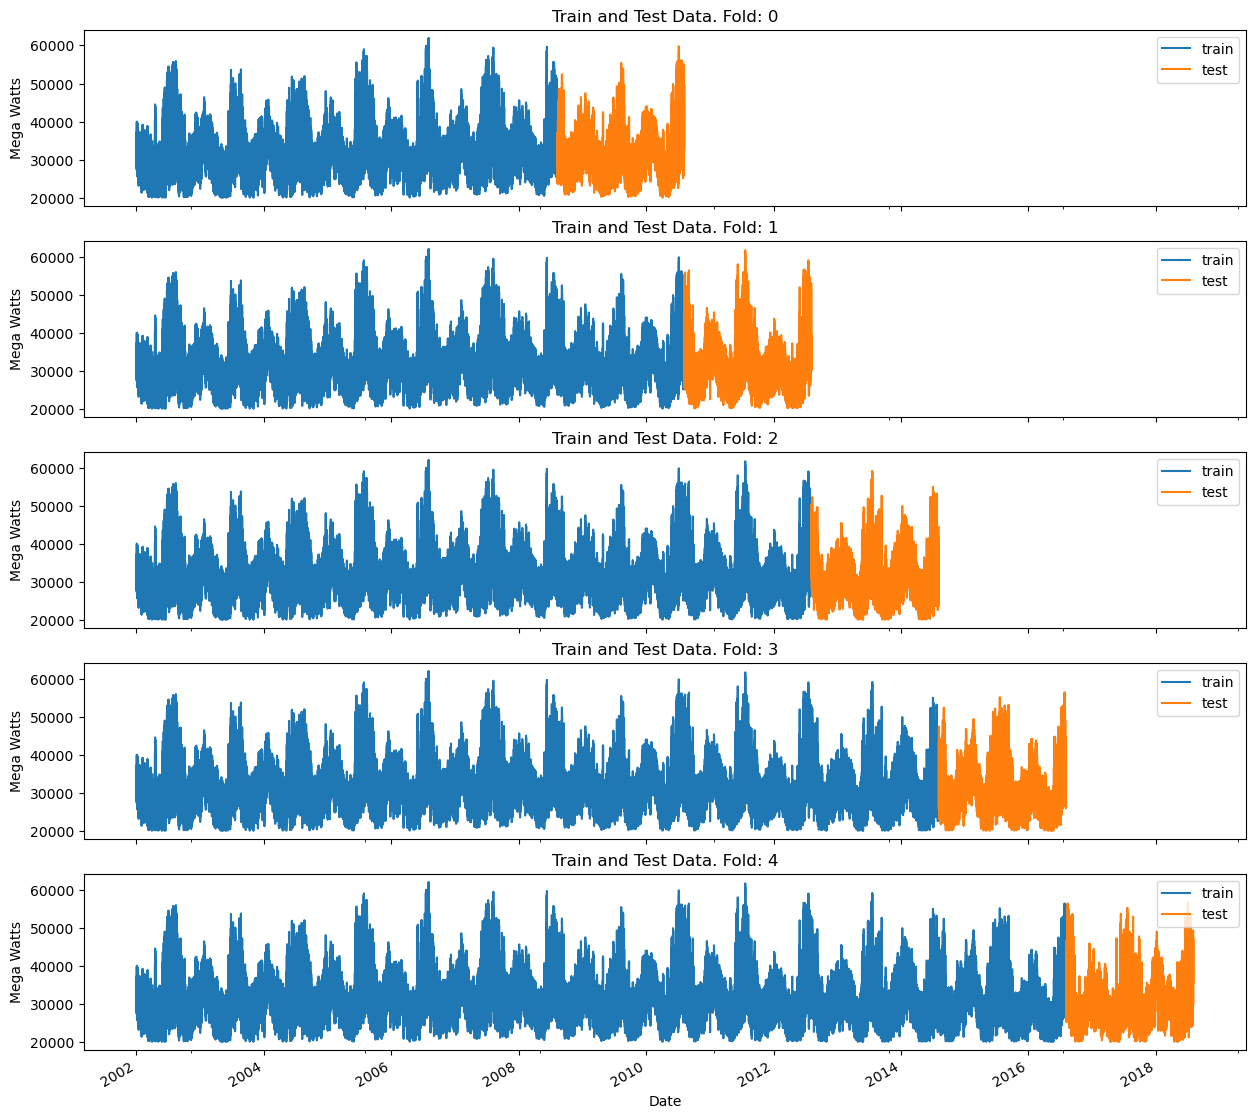

In [53]:
# plot of the train and test data
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 0

for train_idx, test_idx in tss.split(xgb_df):
    train = xgb_df.iloc[train_idx]
    test = xgb_df.iloc[test_idx]

    train['PJME_MW'].plot(ax=axs[fold], title = f'Train and Test Data. Fold: {fold}', label = 'train')
    test['PJME_MW'].plot(ax=axs[fold], label = 'test')

    axs[fold].legend()
    axs[fold].set_xlabel('Date')
    axs[fold].set_ylabel('Mega Watts')

    fold += 1

plt.show()


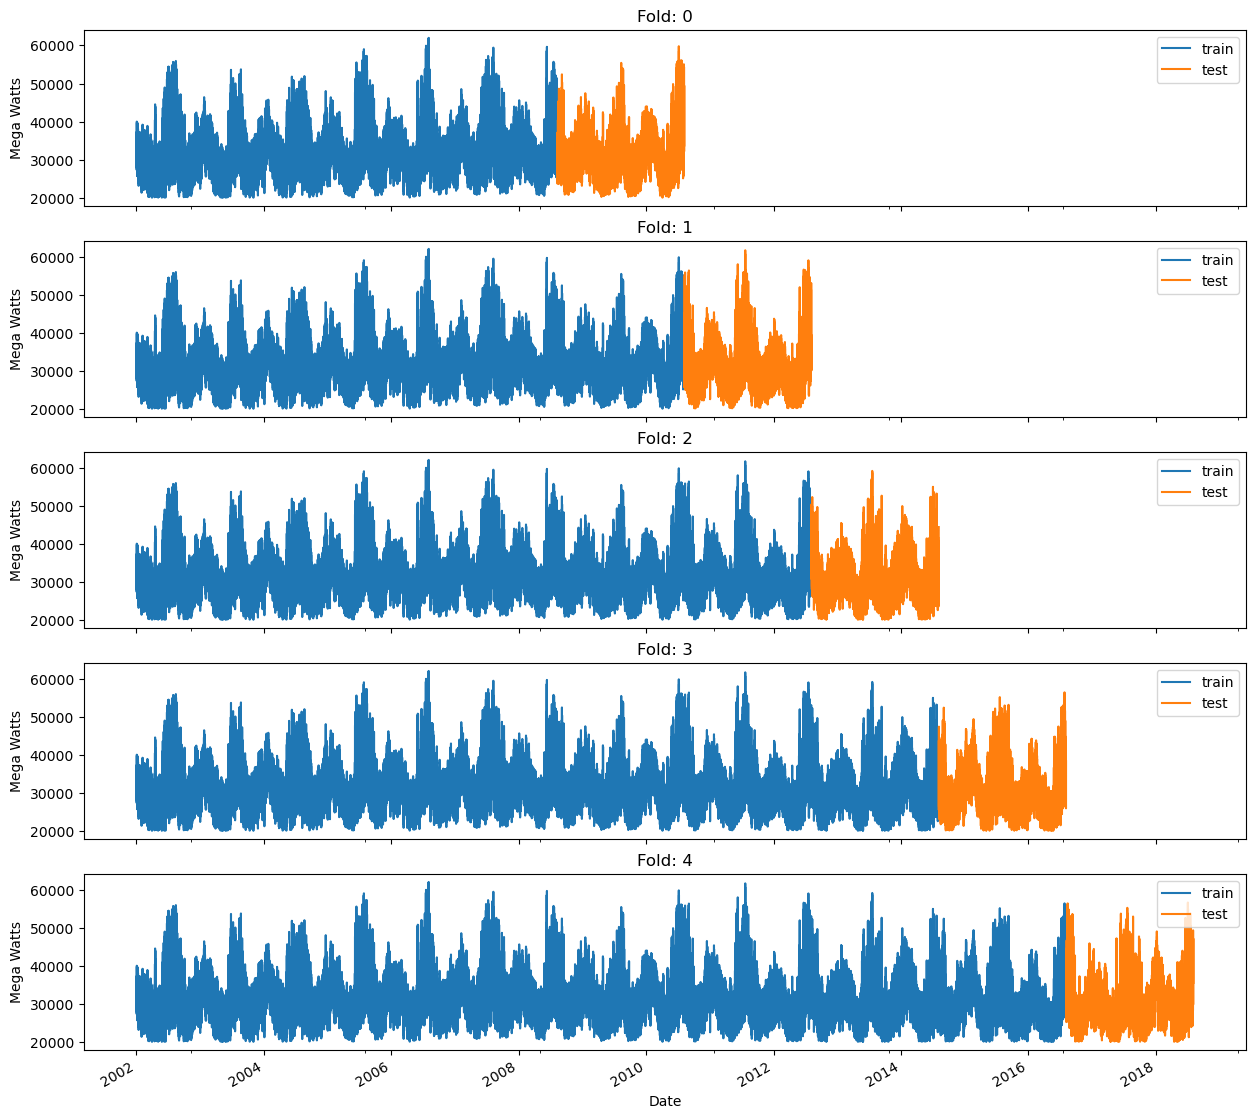

In [54]:
# same plot as above, using emunerate instead
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)


for i, data in enumerate(tss.split(xgb_df)):
    train = xgb_df.iloc[data[0]]
    test = xgb_df.iloc[data[1]]

    train['PJME_MW'].plot(ax=axs[i], title = f'Fold: {i}', label = 'train')
    test['PJME_MW'].plot(ax=axs[i], label = 'test')

    axs[i].legend()
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Mega Watts')

plt.show()

In [55]:
# start_date = '2022-01-03'
# xgb_df = xgb_df.loc[start_date:].copy()

fold = 0
preds = []
rmses = []

for train_idx, test_idx in tss.split(xgb_df):
    train = xgb_df.iloc[train_idx]
    test = xgb_df.iloc[test_idx]

    FEATURES = [
    'hour',
    'dayofweek',
    'month',
    'quarter',
    'year',
    'dayofyear',
    'lag_364',
    'lag_728',
    'lag_1092',
    ]

    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    X_test = test[FEATURES]

    y_train = train[TARGET]
    y_test = test[TARGET]


    # instantiating XGB Regressor
    xgb_reg = xgb.XGBRegressor(
        # base_score = 0.5, # https://stackoverflow.com/questions/47596486/xgboost-the-meaning-of-the-base-score-parameter
        booster = 'gbtree', # gbtree (default), gblinear, dart
        n_estimators = 300,
        early_stopping_rounds = 10,
        objective = 'reg:squarederror', # The XGBoost objective parameter refers to the function to be me minimised. https://datascience.stackexchange.com/questions/64796/what-is-the-difference-between-a-regular-linear-regression-model-and-xgboost-wit
        max_depth = 3,
        learning_rate = 0.01,
        random_state = 22,
    )
    
    xgb_reg.fit(X_train, y_train,
                eval_set = [(X_train, y_train), (X_test, y_test)],
                verbose = 100
    )

    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)

    rmse = root_mean_squared_error(y_test, y_pred)
    rmses.append(rmse)

    fold += 1

[0]	validation_0-rmse:6443.68937	validation_1-rmse:6242.19508
[100]	validation_0-rmse:2428.31922	validation_1-rmse:2353.34576
[200]	validation_0-rmse:975.69971	validation_1-rmse:968.38268
[299]	validation_0-rmse:480.29122	validation_1-rmse:535.18321
[0]	validation_0-rmse:6395.58959	validation_1-rmse:6577.76523
[100]	validation_0-rmse:2408.39022	validation_1-rmse:2483.90395
[200]	validation_0-rmse:969.72443	validation_1-rmse:1025.93563
[299]	validation_0-rmse:483.19458	validation_1-rmse:567.81862
[0]	validation_0-rmse:6428.90785	validation_1-rmse:6229.62430
[100]	validation_0-rmse:2418.15173	validation_1-rmse:2369.08361
[200]	validation_0-rmse:973.85142	validation_1-rmse:1001.43348
[299]	validation_0-rmse:487.59241	validation_1-rmse:569.68114
[0]	validation_0-rmse:6398.70164	validation_1-rmse:6390.68848
[100]	validation_0-rmse:2407.10434	validation_1-rmse:2422.18135
[200]	validation_0-rmse:971.55822	validation_1-rmse:1008.27385
[299]	validation_0-rmse:492.32728	validation_1-rmse:559.597

In [56]:
# print mean fold scores

print(f'Mean Fold RMSE: {np.mean(rmses):.3f}')
# print(f'Fold Scores: {np.round(scores,3)}')
# print(f'Fold Scores: {scores}')
print(f'Fold RMSE: {[f"{i:.3f}" for i in rmses]}')

Mean Fold RMSE: 558.107
Fold RMSE: ['535.183', '567.819', '569.681', '559.597', '558.256']


### XGBoost with GridSearchCV

In [57]:
xgb_reg = xgb.XGBRegressor(
    # base_score = 0.5, # https://stackoverflow.com/questions/47596486/xgboost-the-meaning-of-the-base-score-parameter
    booster = 'gbtree', # gbtree (default), gblinear, dart
    early_stopping_rounds = 10,
    eval_metric = 'rmse',
    # eval_set = [(X_train, y_train), [X_test, y_test]],
    objective = 'reg:squarederror', # The XGBoost objective parameter refers to the function to be me minimised. https://datascience.stackexchange.com/questions/64796/what-is-the-difference-between-a-regular-linear-regression-model-and-xgboost-wit
    random_state = 22,
)

params = {
    'n_estimators' : [300, 800],
    'max_depth' : [3,10],
    'learning_rate' : [0.01, 0.001]
}

xgb_gs = GridSearchCV(
    estimator= xgb_reg,
    cv = tss,
    param_grid= params,
)

fit_params = {
    'eval_set' : [(X_train, y_train), [X_test, y_test]],
}


xgb_gs.fit(X_train, y_train,
           verbose = 100,
           **fit_params
)


[0]	validation_0-rmse:6397.23921	validation_1-rmse:6366.48754
[100]	validation_0-rmse:2420.37694	validation_1-rmse:2441.89397
[200]	validation_0-rmse:1000.31904	validation_1-rmse:1067.68322
[299]	validation_0-rmse:550.85440	validation_1-rmse:660.84979
[0]	validation_0-rmse:6406.15303	validation_1-rmse:6413.99983
[100]	validation_0-rmse:2424.85377	validation_1-rmse:2463.16463
[200]	validation_0-rmse:1001.53906	validation_1-rmse:1078.21622
[299]	validation_0-rmse:542.50456	validation_1-rmse:662.42337
[0]	validation_0-rmse:6404.02554	validation_1-rmse:6405.42315
[100]	validation_0-rmse:2422.25223	validation_1-rmse:2455.54546
[200]	validation_0-rmse:996.03478	validation_1-rmse:1068.63894
[299]	validation_0-rmse:531.14492	validation_1-rmse:648.74966
[0]	validation_0-rmse:6400.89829	validation_1-rmse:6391.07308
[100]	validation_0-rmse:2415.73970	validation_1-rmse:2440.88659
[200]	validation_0-rmse:987.00700	validation_1-rmse:1049.39983
[299]	validation_0-rmse:515.86324	validation_1-rmse:621.

GridSearchCV(cv=TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=17472),
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=30,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=No...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=22, ...),
             param_grid={'learning_rate': [0.01, 0.001], 'max_depth': [10, 30],
                         'n_estimators': [300, 1000]})

In [ ]:
xgb_best = xgb_gs.best_estimator_

In [ ]:
test['Prediction_gscv'] = xgb_gs.predict(X_test)

In [ ]:
rmse = root_mean_squared_error(test['PJME_MW'], test['Prediction_gscv'])
rmse

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(test['PJME_MW'], label='Ground Truth')
plt.plot(test['Prediction_gscv'], label = 'Prediction_gscv')

plt.title('Test Ground Truth vs GridSearchCV Predicted Values')
plt.legend()

plt.tight_layout()

In [ ]:
# check 2 weeks of data

start = '2016-06-14'
end =  '2016-06-28'

plt.figure(figsize=(15,5))

plt.plot(test.loc[start:end, :]['PJME_MW'], ls='--', label='Ground Truth')
plt.plot(test.loc[start:end, :]['Prediction_gscv'], ls='--', label = 'Prediction_gsv')

plt.title('Test Ground Truth vs GridSearchCV Predicted Values (2 Weeks)')
plt.legend()

plt.tight_layout()

### Predict the future

### Refit best xgb estimator with entire dataset to predict future energy consumption

In [68]:
date = pd.Timestamp('today').strftime('%Y-%m-%d')
date

'2024-09-30'

In [60]:
# xgb_best = xgb_gs.best_estimator_
xgb_best.save_model('./model/xgb_best_model_{date}.json')

In [ ]:
X = xgb_df[FEATURES]
y = xgb_df[TARGET]

xgb_best.fit(X,y,
             early_stopping_rounds = 10,
             eval_set = [(X, y)],
             verbose = 200
    )

### Create future prediction dates

In [62]:
prediction_days = 364

start = xgb_df.index.max()
end = xgb_df.index.max() + dt.timedelta(days=prediction_days)

future_dates = pd.date_range(
    start = start, 
    end = end,
    freq = 'h'
    )

future_df = pd.DataFrame(index = future_dates)

future_df['IsFuture'] = True
xgb_df['IsFuture'] = False

xgb_df_future = pd.concat([xgb_df, future_df])

### Create features and add lag features in to xgb_df_future

In [63]:
xgb_df_future = create_features(xgb_df_future)
xgb_df_future = add_lags(xgb_df_future)

In [64]:
# check that futures dates show up
xgb_df_future.tail()

,PJME_MW,hour,month,quarter,year,dayofweek,dayofyear,lag_1,lag_7,lag_14,lag_21,lag_28,lag_63,lag_91,lag_364,IsFuture
2019-08-01 20:00:00,NaN,20,8,3,2019,3,213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-08-01 21:00:00,NaN,21,8,3,2019,3,213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-08-01 22:00:00,NaN,22,8,3,2019,3,213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-08-01 23:00:00,NaN,23,8,3,2019,3,213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-08-02 00:00:00,NaN,0,8,3,2019,4,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


### Predicting the Future

In [65]:
xgb_df_future['pred_future'] = xgb_best.predict(xgb_df[FEATURES])

ValueError: Length of values (145178) does not match length of index (153915)

### Plot out future data

In [ ]:
plt.figure(figsize=(15,5))

# plt.plot(xgb_df_future['PJME_MW'], label='Ground Truth')
# plt.plot(xgb_df_future['pred_future'], label = 'Prediction')

plt.plot(xgb_df_future[xgb_df_future['IsFuture'] == False]['PJME_MW'], label='Ground Truth')
plt.plot(xgb_df_future[xgb_df_future['IsFuture'] == True]['PJME_MW'], label = 'Prediction')

# plt.axvline(start, ls='--', color='black')

plt.title('Ground Truth vs Prediction')
plt.legend()

plt.tight_layout()

In [2253]:
xgb_best.save_model('xgb_model.json')

### Time Series with Prophet

### LSTM

https://www.youtube.com/watch?v=Vfx1L2jh2Ng

In [2254]:
lstm_data = data_df.copy(deep=True)


In [ ]:
lstm_data.isna().sum()

### Create a df for each Exponetial Moving Average

In [2256]:
lstm_ema9_df = data_df[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'EMA_9']].copy(deep=True)
lstm_ema15_df = data_df[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'EMA_15']].copy(deep=True)
lstm_ema30_df = data_df[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'EMA_30']].copy(deep=True)

### Scale data

In [ ]:
lstm_data.values.reshape(-1,1)

In [2258]:
lstm_data_1 = data_df.filter(['Adj Close'])

In [ ]:
lstm_data_1.values

In [2260]:
train_size = 0.75

In [2261]:
# np.ceil() rounds up to the nearest integer. -3.7 is round up to -3
# np.ceil() returns float

train_len = int(np.ceil(len(lstm_data) * 0.75))

In [2262]:
X_train = lstm_data.values[:train_len].reshape(-1,1)

X_test = lstm_data.values[train_len:].reshape(-1,1)

In [2263]:
# scale data
scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(X_train)

# Different Data Set

Resources:

https://xgboosting.com/xgboost-add-lagged-input-variables-for-time-series-forecasting/
https://www.reddit.com/r/MachineLearning/comments/1aoo7gc/d_how_does_xgboost_work_with_time_series/

In [2264]:
# check that the mean of the dataset remains constant
# check if variance of the dataset remains contant
# check for seasonality in dataset

# if yes to 1st and 2nd, and no to 3rd, it means dataset is stationary

# ARIMA, ARIMAX, SARIMAX models assume that the data is stationary.

# if not, we need to make it stationary

In [2265]:
pjm_df = pd.read_csv('./Data_PJM/PJME_hourly.csv', index_col=0, parse_dates=True)

In [ ]:
pjm_df.head()

In [ ]:
plt.plot(pjm_df)

In [2268]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# use augmented adfuller test if you have more than one theta
adfuller(pjm_df)

In [2270]:
aapl_df = data_df['Adj Close'].copy(deep=True)

In [ ]:
# aapl data mean is non-stationary
print(f'AAPL ADF test result: {adfuller(aapl_df)[0]}')
print(f'AAPL p-value: {adfuller(aapl_df)[1]}')

In [ ]:
# this represent theta. if theta is bigger than 1, it mean that the mean of the dataset is going to get bigger. Mean is not stationary
# this represent theta. if theta is less than 1, theta^t will be a constant. it mean that the mean of the dataset is constant. Variance is also constant.
# if theta = 1, mean is constant but variance is not. Not stationary.
print(f'ADF test result: {adfuller(pjm_df)[0]}')

# if p value is very small, we reject the null hypothesis.
print(f'p-value: {adfuller(pjm_df)[1]}')

H0: There is unit root (Data set is not stationary)
H1: There is no unit root (Data set is stationary)

$y_t = \theta y_{t-1} + e_t + \sum$

In [2273]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# shows evidence of seasonality
plot_acf(pjm_df)

In [ ]:
# lags controls how much data is display.
plot_pacf(pjm_df, lags=80)

ACF - measures both the direct and imdirect impact of y-2 on and y (e.g y-2 impact on y, y-2 impact on y-1, and y-1 impact on y)

PACF - measures the direct impact of y-2 on y

In [ ]:
# can be written as:
# data_df.index - pd.Timedelta(364, unit='days')
# data_df.index - pd.Timedelta(5, unit='minutes')
# creates a dictionary using index as key, and target as values
# use 364 /7 gives exact same day of the week

# business day offset
# df.index = df.index - 28 * pd.offsets.CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri')
# pd.tseries.offsets.BusinessDay(n=28)

# def add_lags(df):
#     target_map = df['Adj Close'].to_dict()
#     df['lag_1'] = (df.index - 10).map(target_map)
#     df['lag_2'] = (df.index - pd.Timedelta('56 days')).map(target_map)
#     df['lag_3'] = (df.index - pd.Timedelta('84 days')).map(target_map)
#     df['lag_4'] = (df.index - pd.Timedelta('364 days')).map(target_map)

#     return df

In [ ]:
def add_lags(df):
    df['lag_1'] = df['Adj Close'].shift(7)
    df['lag_2'] = df['Adj Close'].shift(14)
    df['lag_3'] = df['Adj Close'].shift(21)
    df['lag_4'] = df['Adj Close'].shift(30)
    df['lag_5'] = df['Adj Close'].shift(60)

    return df

In [ ]:
# data_df = add_lags(data_df)